In [1]:
import numpy as np
from matplotlib import pyplot as plt

from my_utils import *
from IPython.display import clear_output

In [2]:

# number of particles
n = 100


In [3]:
class grid:
  def __init__(self,x_min,x_max,x_step,y_min,y_max,y_step):
    self.x_min   = x_min
    self.x_max   = x_max
    self.x_step = x_step
    self.y_min   = y_min
    self.y_max   = y_max
    self.y_step = y_step
    self.x_edges = np.arange(x_min,x_max,x_step)
    self.y_edges = np.arange(y_min,y_max,y_step)
    #X, Y = np.meshgrid(self.xedges, self.yedges)
    #self.X = X
    #self.Y = Y
  def pos_to_index(self,x,y):
    j = int( (x-self.x_min)/self.x_step )
    i = int( (y-self.y_min)/self.y_step )
    return (i,j)
    
    

In [4]:
my_grid = grid(-1.5,1.5,.05,-1,1,.05)

In [5]:
class field:
  def __init__(self, grid, nd=1):
    self.grid = grid
    self.nd   = nd
    self.matrix = np.zeros([len(self.grid.y_edges),len(self.grid.x_edges),self.nd])
  def reset_matrix(self):
    self.matrix = np.zeros([len(self.grid.y_edges),len(self.grid.x_edges),self.nd])

In [6]:
class conductor:
  def __init__(self,x_min,x_max,y_min,y_max,color="blue"):
    self.x_min = x_min
    self.x_max = x_max
    self.y_min = y_min
    self.y_max = y_max
    self.color = color

In [7]:
class qcarrier:
  def __init__(self, charge, conductor):
    self.charge = charge
    self.conductor = conductor
    self.x = np.random.random()*(self.conductor.x_max-self.conductor.x_min)+ self.conductor.x_min
    self.y = np.random.random()*(self.conductor.y_max-self.conductor.y_min)+ self.conductor.y_min

In [8]:
c1 = conductor(-1.4,1.4,-0.5,0)
c2 = conductor(-.3,.3,0.1,0.3)

In [9]:
particles = []

for i in range(int(n/2)):
    particles += [qcarrier(-1,c1)]
    particles += [qcarrier(+1,c2)]


In [10]:
def plot_particles(p_list):
    charges = [-1,+1]
    
    for charge in charges:
        x = []
        y = []
        for p in p_list:
            if p.charge == charge:
                x += [p.x]
                y += [p.y]
        plt.scatter(x,y,label="q = {}".format(charge))
    plt.legend()
    


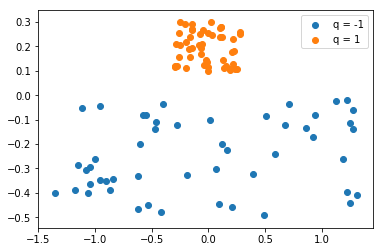

In [11]:
plot_particles(particles)

In [12]:
q_density = field(my_grid)

In [13]:
def q_density_from_charges(q_density,p_list):
    q_density.reset_matrix()
    for particle in p_list:
        
        i,j = q_density.grid.pos_to_index(particle.x,particle.y)
        q_density.matrix[i,j,0] += particle.charge
        
    

In [14]:
q_density_from_charges(q_density,particles)

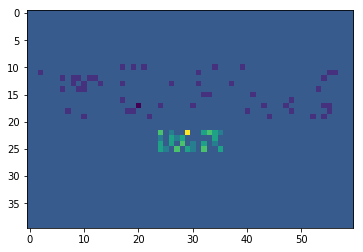

In [15]:
plt.imshow(q_density.matrix[:,:,0])

In [16]:
e_field = field(my_grid,nd=2)

In [17]:
def e_field_from_q_density(e_field,q_density):
    grid = e_field.grid
    
    e_field.reset_matrix()
    
    for ei in range(len(grid.y_edges)):
        ey = grid.y_edges[ei]
        for ej in range(len(grid.x_edges)):
            ex = grid.x_edges[ej]
    
            for qi in range(len(grid.y_edges)):
                qy = grid.y_edges[qi]
                for qj in range(len(grid.x_edges)):
                    qx = grid.x_edges[qj]
                    
                    Q = q_density.matrix[qi,qj,0]
                    
                    # no charge here, no contribution to the field
                    if Q == 0:
                        continue
                        
                    # for the time being don't handle r^2 == 0
                    if (qi == ei) and (qj == ej):
                        continue
                        
                    
                    delta_x = qx-ex
                    delta_y = qy-ey
                    rr = delta_x*delta_x + delta_y*delta_y
                    r = np.sqrt(rr)
                    delta_E_x = -Q/rr * delta_x/r
                    delta_E_y = -Q/rr * delta_y/r
                    
                    e_field.matrix[ei,ej,0] += delta_E_x
                    e_field.matrix[ei,ej,1] += delta_E_y

In [18]:
e_field_from_q_density(e_field,q_density)

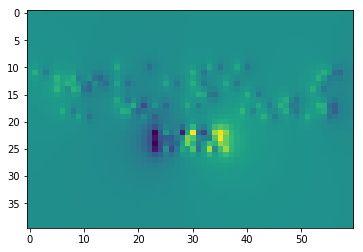

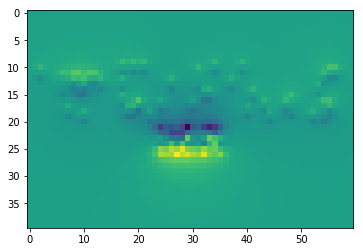

In [19]:
plt.imshow(e_field.matrix[:,:,0])
plt.show()
plt.imshow(e_field.matrix[:,:,1])
plt.show()

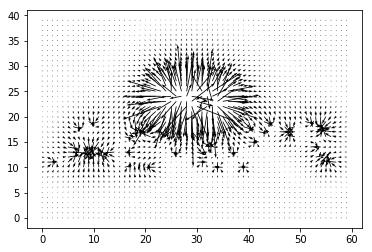

In [20]:
plt.quiver(e_field.matrix[:,:,0],e_field.matrix[:,:,1])

In [21]:
def move_particles(e_field,p_list,strength):
    for particle in p_list:
        i,j = e_field.grid.pos_to_index(particle.x,particle.y)
        
        force_x = e_field.matrix[i,j,0] * particle.charge * strength
        force_y = e_field.matrix[i,j,1] * particle.charge * strength
        
        particle.x += force_x
        particle.y += force_y
        
        if particle.x > particle.conductor.x_max:
            particle.x = particle.conductor.x_max
        elif particle.x < particle.conductor.x_min:
            particle.x = particle.conductor.x_min
            
        if particle.y > particle.conductor.y_max:
            particle.y = particle.conductor.y_max
        elif particle.y < particle.conductor.y_min:
            particle.y = particle.conductor.y_min

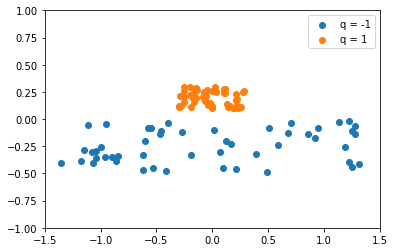

In [22]:

plot_particles(particles)
plt.xlim(-1.5,1.5)
plt.ylim(-1,1)
plt.show()

saving to /workdir/jupyter/misc_mw/field_solver/stupid_solver_trace_anim/049.png


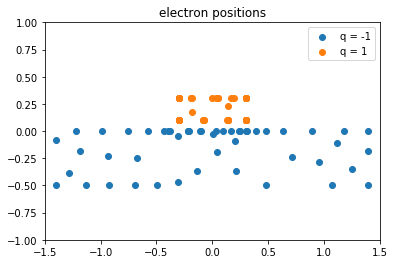

In [23]:
timesteps = 50

clear_animation_cache()

for t in range(timesteps):
    clear_output(wait=True)
    plot_particles(particles)
    plt.xlim(-1.5,1.5)
    plt.ylim(-1,1)
    plt.title("electron positions")
    save_animation_frame(plt)
    plt.show()
    q_density_from_charges(q_density,particles)
    e_field_from_q_density(e_field,q_density)
    move_particles(e_field,particles,1e-4)

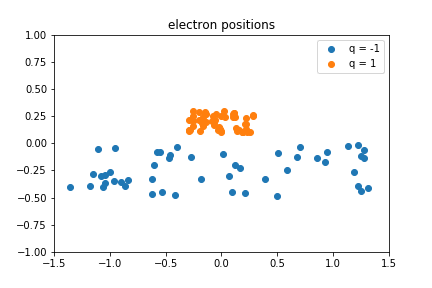

In [24]:
make_gif()

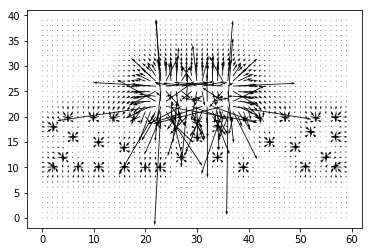

In [25]:
plt.quiver(e_field.matrix[:,:,0],e_field.matrix[:,:,1])
plt.show()

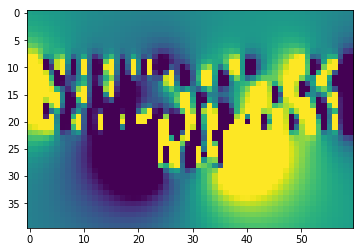

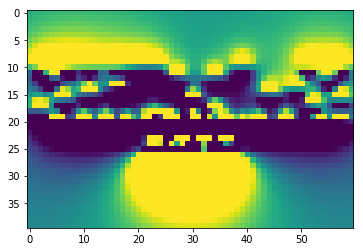

In [26]:
cscale=50

plt.imshow(e_field.matrix[:,:,0])
plt.clim(-cscale,cscale)
plt.show()
plt.imshow(e_field.matrix[:,:,1])
plt.clim(-cscale,cscale)
plt.show()